# 90803 Data Cleaning and Question Definition
# Merge Covid Data (county level) with ACS data (city level)

#### This file takes the dataframe from step 2 and converts it to the city level using averaging over geometries.

**Team 14**

Colton Lapp & Chi-Shiun Tsai

In [1]:
#import modules 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from census import Census
from us import states
import numpy as np
import os
import seaborn as sns

## Read in covid data
#### Convert deaths/cases per capita to "per 100K"

In [2]:
#Read in DFs
base_dir = '/'.join( os.getcwd().split('/')[0:-1] )
base_dir
covid = pd.read_csv(base_dir+ '/data/data_cleaned/covid.csv')
covid = covid.rename( {'fips':'GEOID'}, axis=1)

#Convert cases and deaths to per 100K
covid['cases'] = covid['cases'] *100000
covid['deaths'] = covid['deaths'] *100000

#Rename
covid=covid.rename( {"cases":"cases_per_100K","deaths":"deaths_per_100K" }, axis=1)
covid

,county,state,GEOID,cases_per_100K,deaths_per_100K,year
0,Abbeville,South Carolina,45001,5186.721992,101.700431,2020
1,Acadia,Louisiana,22001,8148.017508,245.306312,2020
2,Accomack,Virginia,51001,5214.987715,82.923833,2020
3,Ada,Idaho,16001,8183.005199,75.616702,2020
4,Adair,Iowa,19001,8598.183882,241.203178,2020
...,...,...,...,...,...,...
3138,Yuma,Arizona,4027,12912.693282,244.891026,2020
3139,Yuma,Colorado,8125,5482.872266,129.831219,2020
3140,Zapata,Texas,48505,6726.111072,70.209928,2020
3141,Zavala,Texas,48507,7912.824811,209.555742,2020


## Download County Shape Files from Census website

In [3]:
#Download from Census website
counties_shp = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_500k.zip")
counties_shp.head(2)


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,20,161,00485044,0500000US20161,20161,Riley,Riley County,KS,Kansas,06,1579077672,32047392,"POLYGON ((-96.96095 39.28670, -96.96106 39.288..."
1,19,159,00465268,0500000US19159,19159,Ringgold,Ringgold County,IA,Iowa,06,1386932347,8723135,"POLYGON ((-94.47167 40.81255, -94.47166 40.819..."


# Merge county covid data and county shapefiles
Merge on GEOID which is a unique census id for every county

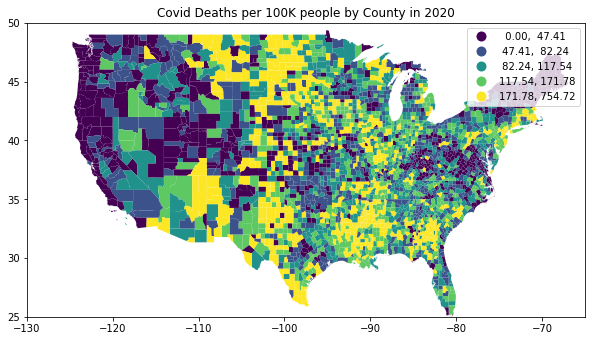

In [4]:
#Convert shp file GEOID to int
counties_shp['GEOID'] = counties_shp['GEOID'].astype(str).astype(int)

#Merge
covid_merged =  covid.merge(counties_shp, on ='GEOID' )

#Convert to GeoDF 
covid_merged =  gpd.GeoDataFrame(covid_merged)

#Plot (just to make sure it looks okay)
fig, ax = plt.subplots(1, 1, figsize = (10,10))
covid_merged.plot(column='deaths_per_100K', ax=ax, kind='geo', legend=True, scheme='quantiles')
plt.xlim([-130,-65])
plt.ylim([25,50])
plt.title("Covid Deaths per 100K people by County in 2020")
plt.show()


## Read in "places" shape file
Note: this shape file is created in the download_ACS_data_city_level.ipynb file (step 1). If you don't have it in your directory go back and run step 1 again

In [5]:
places_shp = gpd.read_file( base_dir + '/data/shape_files/CensusPlaces')
places_shp.head(1)

,STATEFP,PLACEFP,PLACENS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,PCICBSA,PCINECTA,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,01,05932,02405250,0105932,Berry,Berry town,43,C1,N,N,G4110,A,27884733,15029,+33.6667018,-087.6093110,"POLYGON ((-87.63910 33.66662, -87.63794 33.666..."


### Change Coordinate Reference System to be Albers equal area

In [6]:
#Change Coordinate refernece system to albert equal area
places_shp = places_shp.to_crs(crs = 9822)
covid_merged = covid_merged.to_crs(crs = 9822)

# Create City Level Covid Data by Intersecting county and city shape files

#### We will overlay the city shapes on top of the county. We will then create intersections between the two shapes. We will finally compute city averages as the counties that intersect them

In [7]:
# create areas of intersection
df_is = gpd.overlay(covid_merged, places_shp, how='intersection')

/var/folders/xm/xqtx9_vj3398yls687yyxg180000gn/T/ipykernel_97343/2995094026.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 37393 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  df_is = gpd.overlay(covid_merged, places_shp, how='intersection')


In [8]:
# sum over cities and years
df_weighted_avg = df_is.groupby(['GEOID_2', 'NAMELSAD_2', 'year'])[['cases_per_100K', 'deaths_per_100K']].mean() 
df_weighted_avg = df_weighted_avg.reset_index()

df_weighted_avg.head()

,GEOID_2,NAMELSAD_2,year,cases_per_100K,deaths_per_100K
0,0100100,Abanda CDP,2020,6240.090741,160.221474
1,0100124,Abbeville city,2020,7282.602348,46.720785
2,0100460,Adamsville city,2020,7946.827813,105.828139
3,0100484,Addison town,2020,8299.595142,126.518219
4,0100676,Akron town,2020,9760.065067,223.668158


# Rename Variables and Save Data Frame

In [9]:
#Rename
print("Final shape of datset it:", df_weighted_avg.shape)

df_weighted_avg = df_weighted_avg.rename( {'GEOID_2':'GEOID', 'NAMELSAD_2': 'NAMELSAD'}, axis=1)

#Save
df_weighted_avg.to_csv( base_dir + '/data/data_cleaned/covid_cities.csv', index=False)

Final shape of datset it: (29357, 5)


# Map to Check

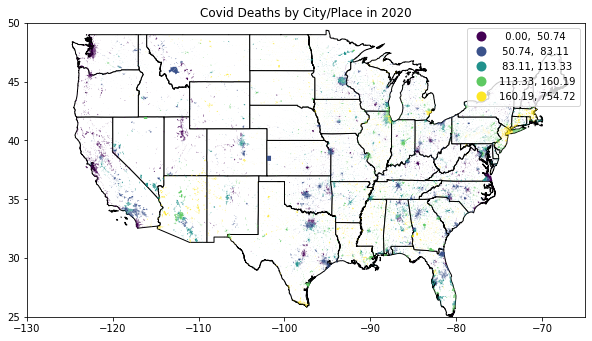

In [10]:
#Join places shapes back to df
df = df_weighted_avg.merge(places_shp, on='GEOID')
df = gpd.GeoDataFrame(df)

#Read in States Shape file
#Download USA 48 states shapefile
usa_shp = gpd.read_file(base_dir +'/data/shape_files/USStates/US_States.shp')

#Plot states
fig, ax = plt.subplots(1, 1, figsize = (10,10))
base = usa_shp.plot(color='white', edgecolor='black', ax = ax)
plt.xlim([-130, -65])
plt.ylim([25,50])

#Convert CRS system of df
df = df.to_crs(usa_shp.crs)

#Plot covid deaths
df[df['year']==2020 ].plot(column='deaths_per_100K', ax=ax, kind='geo', legend=True, scheme='quantiles')
plt.title("Covid Deaths by City/Place in 2020")
plt.show()

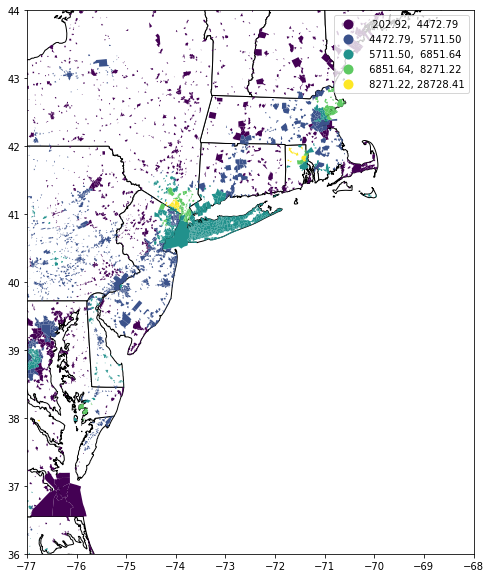

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
base = usa_shp.plot(color='white', edgecolor='black', ax = ax)
df[df['year']==2020 ].plot(column='cases_per_100K', ax=ax, kind='geo', legend=True, scheme='quantiles')
plt.xlim([-77, -68])
plt.ylim([36,44])
plt.show()

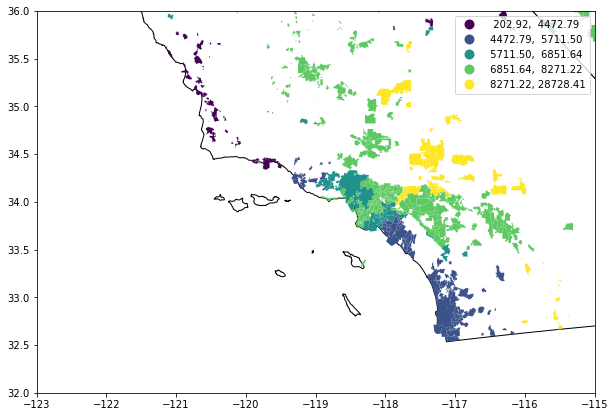

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
base = usa_shp.plot(color='white', edgecolor='black', ax = ax)
df[df['year']==2020 ].plot(column='cases_per_100K', ax=ax, kind='geo', legend=True, scheme='quantiles')
plt.xlim([-123, -115])
plt.ylim([32,36])
plt.show()

### References

1. https://gis.stackexchange.com/questions/436463/weighted-average-values-of-overlapping-polygons-in-python